In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numdifftools as ndt
from scipy.stats import f

In [2]:
# load flow rate data
flow_data = pd.read_csv('flow_data.csv')
lc_data = pd.read_csv('lc_data.csv')
teaf      = 0.00721
teaden    = 0.728
cBf = teaf

In [3]:
tQf = np.insert(flow_data['t'].values, 0, 0)
Qf = np.insert(flow_data["Qf"].values / teaden, 0, 0)

In [4]:
tlc = lc_data['t'].values
lc = lc_data['lc_meas'].values

In [5]:
Qf_if = interp1d(tQf, Qf, 'previous', bounds_error = False)

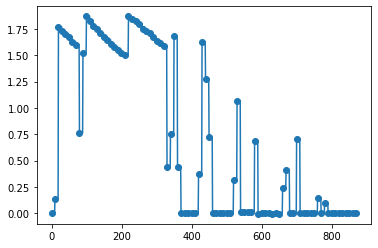

In [6]:
t_i = np.arange(0.0, 850.0)
Qf_i = [Qf_if(t) for t in t_i]

fig, ax = plt.subplots()
ax.scatter(tQf, Qf)
ax.plot(t_i, Qf_i)

In [10]:
def rates(t, y, p):
    vR = y[0]
    nA = y[1]
    nB = y[2]
    nC = y[3]
    nD = y[4]
    
    Qf_if = p[0]
    k1 = p[1]
    k2 = p[2]
    
    cBf = 0.00721
    
    dvR = Qf_if
    dnA = -k1 * nA * nB / vR
    dnB = Qf_if * cBf - nB * (k1 * nA + k2 * nC) / vR
    dnC = nB * (k1 * nA - k2 * nC) / vR
    dnD = k2 * nC * nB / vR
    
    return [dvR, dnA, dnB, dnC, dnD]

In [11]:
def simprob(p, tQf, Qf):

    y0 = [2370.0, p[0], 0.0, 0.0, 0.0]

    for (i, t) in enumerate(tQf[:-1]):
        #print(i)
        tspan = [0.0, tQf[i+1] - tQf[i]]
        p_ext = [Qf[i], p[1], p[2]]
        sol = solve_ivp(rates, tspan, y0, method = "BDF", args = (p_ext,))
        sol.t = sol.t + tQf[i]
        y0 = sol.y[:,-1]
        if i == 0:
            sol_l_t = np.copy(sol.t)
            sol_l_y = np.copy(sol.y)
        else:
            sol_l_t = np.concatenate((sol_l_t, sol.t))
            sol_l_y = np.concatenate((sol_l_y, sol.y), axis = 1)
            
    return sol_l_t, sol_l_y

In [33]:
def get_lcpred(sol):
    
    lc_pred =  1 / (1 + 2.0*sol[1,:]/np.maximum(sol[0,:], 1e-6))
    
    return lc_pred

In [40]:
def get_lc_sse(sol_l_t, sol_l_y, lc_data):
    tlc = lc_data['t'].values
    lc = lc_data['lc_meas'].values
    sol_nC_int = interp1d(sol_l_t, sol_l_y[3,:], 'linear', bounds_error = False)
    sol_nD_int = interp1d(sol_l_t, sol_l_y[4,:], 'linear', bounds_error = False)
    sol_nC = np.array([sol_nC_int(t) for t in tlc])
    sol_nD = np.array([sol_nD_int(t) for t in tlc])
    sol = np.vstack((sol_nC, sol_nD))
    lc_pred = get_lcpred(sol)
    lc_ratio = lc_pred/lc
    sse = np.sum((lc_ratio - 1.0)**2)
    return sse

In [12]:
sol_l_t, sol_l_y = simprob([2.35, 2500.0, 1250.0], tQf, Qf)

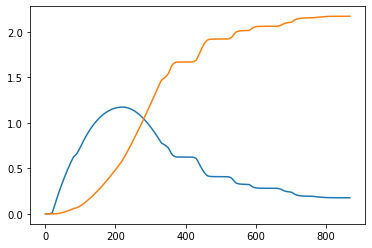

In [31]:
fig, ax = plt.subplots()
ax.plot(sol_l_t, sol_l_y[3,:])
ax.plot(sol_l_t, sol_l_y[4,:])

In [34]:
lc_sim = get_lcpred(sol_l_y[3:5,:])
lc_sim

array([1.        , 1.        , 1.        , ..., 0.03919378, 0.03919223,
       0.03918117])

(0.0, 0.2)

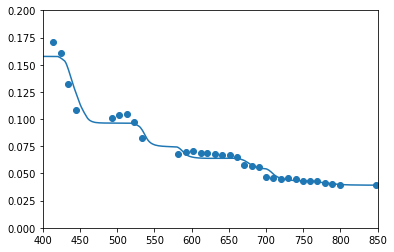

In [36]:
fig, ax = plt.subplots()
ax.scatter(tlc, lc)
ax.plot(sol_l_t, lc_sim)
ax.set_xlim([400.0, 850.0])
ax.set_ylim([0.0, 0.2])

In [41]:
tmp = get_lc_sse(sol_l_t, sol_l_y, lc_data)
tmp

0.14569256212298504

In [42]:
def calc_SSE(pest, data):
    sol_l_t, sol_l_y = simprob(pest, data['tQf'], data['Qf'])
    SSE = get_lc_sse(sol_l_t, sol_l_y, data['lc_data'])
    return SSE

In [43]:
pest_data = {'Qf_if': Qf_if, 'lc_data': lc_data, 'tQf': tQf, 'Qf': Qf}

In [44]:
calc_SSE([2.35, 2500.0, 1250.0], pest_data)

0.14569256212298504

In [55]:
pe_sol = minimize(calc_SSE, [2.35, 1000.0, 1000.0], args = pest_data, method = "L-BFGS-B")

In [56]:
pe_sol

      fun: 0.17361418268192358
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.21933020e-04, -3.02205903e-05, -3.18161911e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 272
      nit: 35
     njev: 68
   status: 0
  success: True
        x: array([   2.34880653, 1301.85294678,  695.06513228])

In [45]:
calc_SSE_lam = lambda pest: calc_SSE(pest, pest_data)

In [46]:
Hfn = ndt.Hessian(calc_SSE_lam)

In [47]:
H = Hfn([2.35, 2500.0, 1250.0])

In [48]:
H

array([[ 3.60046534e+03,  4.31843708e-02, -9.50247636e-02],
       [ 4.31843708e-02,  6.75469007e-07, -1.51589774e-06],
       [-9.50247636e-02, -1.51589774e-06,  3.44908690e-06]])

In [49]:
np.linalg.inv(H) 

array([[ 1.30941342e-03, -2.01682557e+02, -5.25656315e+01],
       [-2.01682557e+02,  1.39507767e+08,  5.57581402e+07],
       [-5.25656315e+01,  5.57581402e+07,  2.33478031e+07]])

In [50]:
nparam = 2
ndata = 35
mse = calc_SSE([2.35, 2500.0, 1250.0], pest_data)/(ndata - nparam)
mse

0.004414926124938941

In [51]:
cov_est = 2 * mse * np.linalg.inv(H)
cov_est

array([[ 1.15619270e-05, -1.78082718e+00, -4.64146760e-01],
       [-1.78082718e+00,  1.23183297e+06,  4.92336140e+05],
       [-4.64146760e-01,  4.92336140e+05,  2.06157652e+05]])

In [53]:
nparam = 2
ndata = 35
alpha = 0.95
mult_factor = nparam * f.ppf(alpha, nparam, ndata - nparam)
mult_factor

6.5698353020765765

In [54]:
conf_delta = np.sqrt(np.diag(cov_est) * mult_factor)
conf_delta

array([8.71550092e-03, 2.84480926e+03, 1.16379630e+03])